# FuzzyART com a base de dados Iris

FuzzyART é o modelo ART mais usado.

## Importando bibliotecas e baixando base de dados

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from artlib import FuzzyART
from sklearn.metrics import accuracy_score
import pandas as pd

X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Teste com vários hiperparâmetros

<font color="#6fa849ff">**Entendendo os parâmetros**</font> 

- Beta ($\beta$): Fica no intervalo (0,1] e é o parâmetro de aprendizado. Quando $\beta = 1$, dizemos que o modelo está no modo de aprendizado rápido.
    - Controla a atualização dos pesos.

- Rho ($\rho$): Parâmetro de vigilância. Se $M_j(x) < \rho$, a categoria é rejeitada. 
    - Obs.: $M_j$ é a função "match", $M_j(x)$ mede o quanto uma entrada x é coberta pela categoria j.
    - Um $\rho$ alto causa mais categorias, mais especificidade e menor generalização.
    - É o parâmetro que mais afeta a ocorrência de under/overfitting.

- Alpha ($\alpha$): Parâmetro de escolha, controla a divisão por zero.

<font color="#6fa849ff">**Definição dos limites para os valores dos dados**</font> 

Para isso, juntaremos todos os dados (treino e teste) e deixaremos o modelo calcular os limites de forma automática:

```python
lower_bound, upper_bound = model.find_data_bounds(X)
model.set_data_bounds(lower_bound, upper_bound)
```

<font color="red">Dúvida:</font>
O README da biblioteca ARTlib diz: "Se o primeiro lote ("batch") dos seus dados de treinamento for representativo de todo o espaço de dados você não precisa fazer nada e a artlib vai identificar os limites dos dadso automaticamente." 

Nesse caso, como todos os dados que são utilizados já estão em X, acredito que essa normalização não é necessária.


In [2]:
alphas = [1e-6, 1e-3, 1e-2, 1e-1, 1.0, 10.0] 
rhos   = [0.1, 0.3, 0.5, 0.7, 0.9]
betas  = [1.0, 0.5, 0.1]

results = []

for alpha in alphas:
    for rho in rhos:
        for beta in betas:

            model = FuzzyART(rho=rho, alpha=alpha, beta=beta)
            
            lower_bound, upper_bound = model.find_data_bounds(X)
            model.set_data_bounds(lower_bound, upper_bound)

            # Preparar os dados (normalizados internamente pelo modelo)
            train_X_prep = model.prepare_data(X_train)
            test_X_prep  = model.prepare_data(X_test)

            # Treinar
            model.fit(train_X_prep, y_train)

            # Prever
            predictions = model.predict(test_X_prep)

            # Calcular accuracy
            acc = accuracy_score(y_test, predictions)

            results.append({
                'alpha': alpha,
                'rho': rho,
                'beta': beta,
                'accuracy': acc
            })

            #print(f"alpha={alpha:.1e}, rho={rho}, beta={beta} → acc={acc:.3f}")

df_results = pd.DataFrame(results)
best_results = df_results.sort_values(by='accuracy', ascending=False).head(10)


In [3]:
print("10 melhores combinações:")
print(best_results)

10 melhores combinações:
        alpha  rho  beta  accuracy
80  10.000000  0.3   0.1  0.650000
45   0.100000  0.1   1.0  0.633333
63   1.000000  0.3   1.0  0.433333
75  10.000000  0.1   1.0  0.400000
60   1.000000  0.1   1.0  0.383333
6    0.000001  0.5   1.0  0.383333
36   0.010000  0.5   1.0  0.383333
21   0.001000  0.5   1.0  0.383333
51   0.100000  0.5   1.0  0.366667
65   1.000000  0.3   0.1  0.350000


## Gráficos dos melhores resultados

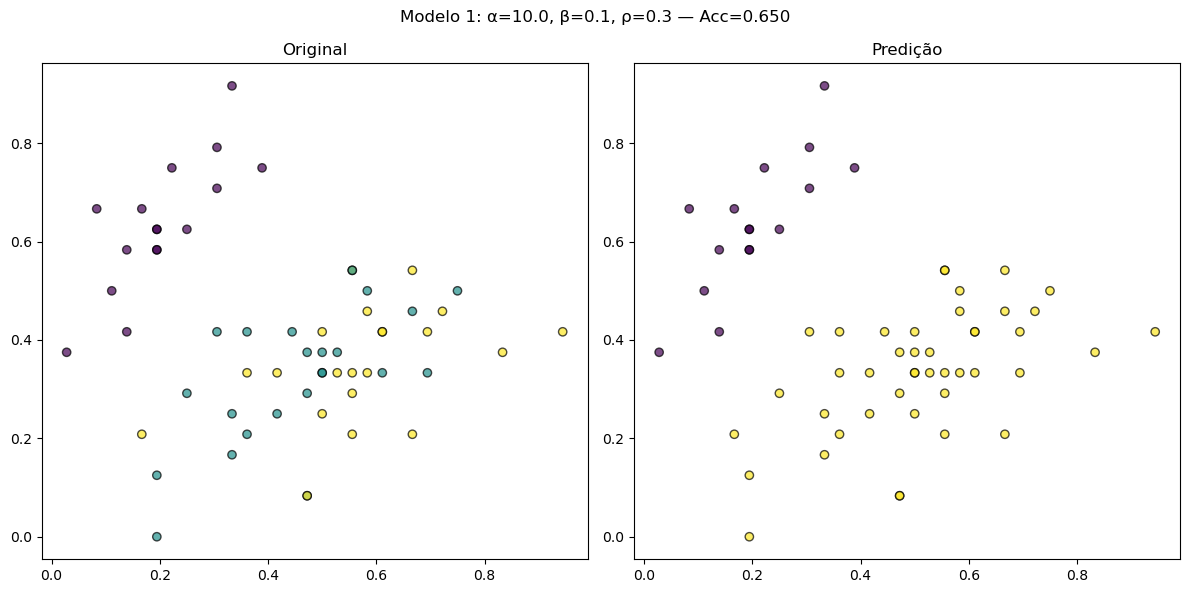

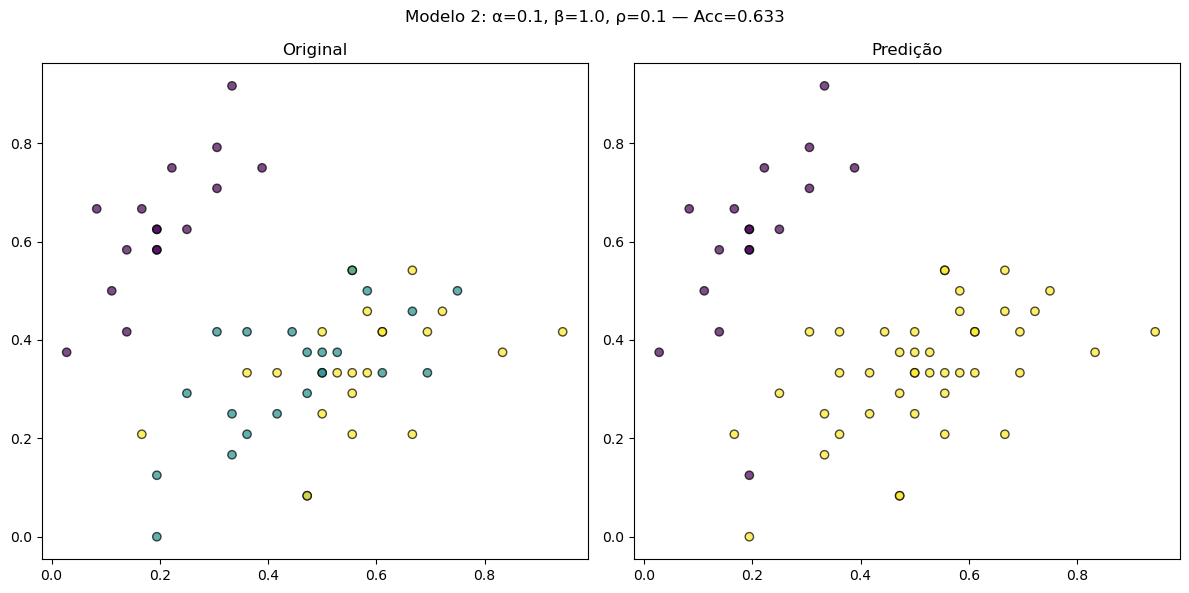

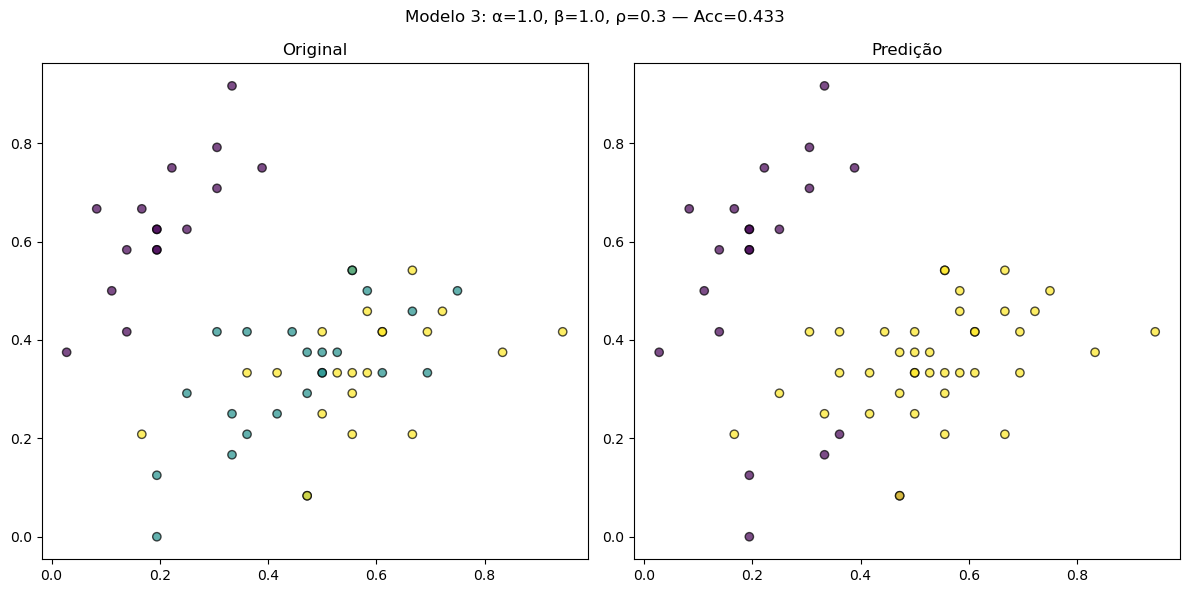

In [5]:
for i in range(0, 3):
    values = best_results.iloc[i]
    model = FuzzyART(rho=values['rho'], alpha=values['alpha'], beta=values['beta'])

    lower_bound, upper_bound = model.find_data_bounds(X)
    model.set_data_bounds(lower_bound, upper_bound)

    # Preparar os dados (normalizados internamente pelo modelo)
    train_X_prep = model.prepare_data(X_train)
    test_X_prep  = model.prepare_data(X_test)

    # Treinar
    model.fit(train_X_prep, y_train)

    # Prever
    predictions = model.predict(test_X_prep)

    f, subplots = plt.subplots(1, 2, figsize=(12, 6))

    subplots[0].scatter(
        test_X_prep[:, 0],
        test_X_prep[:, 1],  # coordenadas x e y
        c=y_test,  # cor de acordo com a classe (0 ou 1)
        edgecolors="k",  # contorno preto em cada ponto
        alpha=0.7,
    )
    subplots[0].set_title("Original")
    
    subplots[1].scatter(
        test_X_prep[:, 0],
        test_X_prep[:, 1],  # coordenadas x e y
        c=predictions,  # cor de acordo com a classe (0 ou 1)
        edgecolors="k",  # contorno preto em cada ponto
        alpha=0.7,
    )
    subplots[1].set_title("Predição")

    f.suptitle(f"Modelo {i+1}: α={values['alpha']}, β={values['beta']}, ρ={values['rho']} — Acc={values['accuracy']:.3f}",
                 fontsize=12)
    plt.tight_layout()
    plt.show()

## Bounds do melhor resultado

In [8]:
best_result = df_results.sort_values(by='accuracy', ascending=False).iloc[0]

print("Melhor combinação:")
print(best_result)

## Treinar o melhor modelo
best_model = FuzzyART(rho=best_result['rho'], alpha=best_result['alpha'], beta=best_result['beta'])

lower_bound, upper_bound = best_model.find_data_bounds(X)
best_model.set_data_bounds(lower_bound, upper_bound)

# Preparar os dados
train_X_prep = best_model.prepare_data(X_train)
test_X_prep = best_model.prepare_data(X_test)

# Treinar
best_model.fit(train_X_prep, y_train)

# Prever
predictions = best_model.predict(test_X_prep)

# Calcular accuracy final
final_acc = accuracy_score(y_test, predictions)
print(f"\nAcurácia final do melhor modelo: {final_acc:.3f}")
print(f"Número de clusters formados: {len(best_model.W)}")


Melhor combinação:
alpha       10.00
rho          0.30
beta         0.10
accuracy     0.65
Name: 80, dtype: float64

Acurácia final do melhor modelo: 0.650
Número de clusters formados: 2


Erro ao plotar fronteiras: boolean index did not match indexed array along dimension 1; dimension is 8 but corresponding boolean dimension is 4


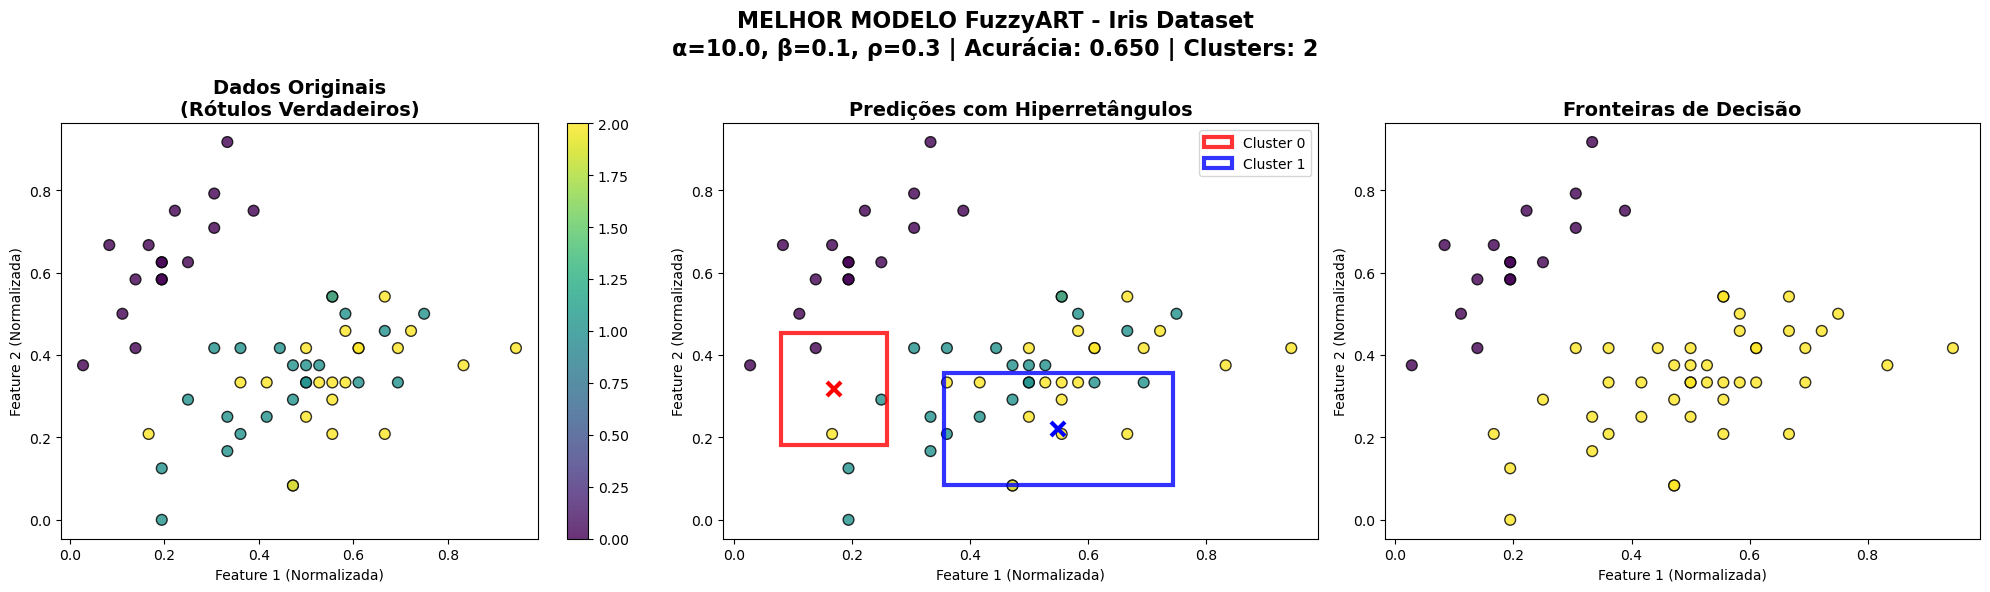


ANÁLISE DETALHADA DOS HIPERRETÂNGULOS

Número de clusters formados: 2

Pesos dos hiperretângulos (primeiras 2 dimensões para visualização):

Cluster 0:
  Peso (vértice): [0.1700, 0.3169, ...]
  Pontos no cluster: 16
  Rótulos verdadeiros: [16]
  Centroide real: [0.2031, 0.6354]
  Extensão X: 0.3611
  Extensão Y: 0.5417

Cluster 1:
  Peso (vértice): [0.5498, 0.2205, ...]
  Pontos no cluster: 44
  Rótulos verdadeiros: [ 0 23 21]
  Centroide real: [0.5133, 0.3352]
  Extensão X: 0.7778
  Extensão Y: 0.5417

MATRIZ DE CONFUSÃO


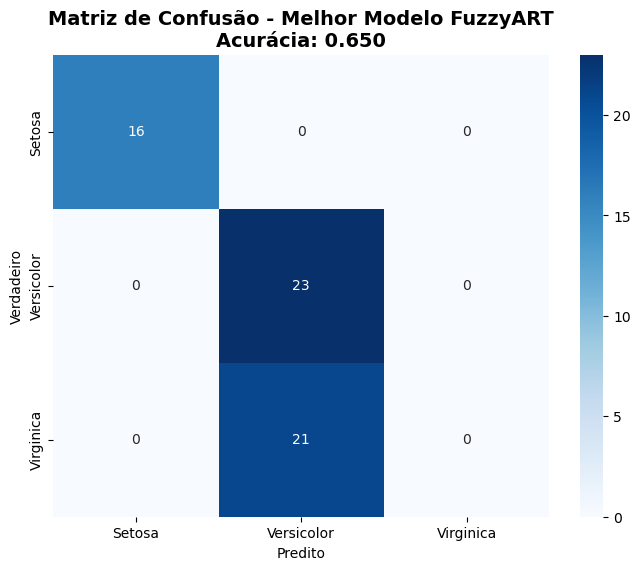


Relatório de Classificação:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        16
  Versicolor       0.52      1.00      0.69        23
   Virginica       0.00      0.00      0.00        21

    accuracy                           0.65        60
   macro avg       0.51      0.67      0.56        60
weighted avg       0.47      0.65      0.53        60



/home/marina/Downloads/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/marina/Downloads/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/marina/Downloads/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [9]:
## Função para plotar hiperretângulos
def plot_hyperrectangles_2d(model, X_data, true_labels, predictions, ax, title):
    """Plota os dados e os hiperretângulos do modelo FuzzyART em 2D"""
    
    # Plotar os pontos com cores verdadeiras
    scatter = ax.scatter(
        X_data[:, 0],
        X_data[:, 1],
        c=true_labels,
        cmap='viridis',
        edgecolors="k",
        alpha=0.8,
        s=60
    )
    
    # Obter os pesos do modelo
    weights = model.W
    
    # Cores para os hiperretângulos
    cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Plotar cada hiperretângulo
    for i, w in enumerate(weights):
        if len(w) >= 2:
            # No FuzzyART, os pesos definem os cantos dos hiperretângulos
            # Para visualização, vamos usar uma abordagem simplificada
            center_x = w[0]
            center_y = w[1]
            
            # Estimar o tamanho baseado na distribuição dos dados no cluster
            cluster_points = X_data[predictions == i]
            if len(cluster_points) > 0:
                # Calcular extensão do cluster nas duas dimensões
                if len(cluster_points) > 1:
                    x_range = np.ptp(cluster_points[:, 0]) * 0.5
                    y_range = np.ptp(cluster_points[:, 1]) * 0.5
                else:
                    x_range = 0.1
                    y_range = 0.1
                
                # Criar retângulo representando o hiperretângulo
                rect = plt.Rectangle((center_x - x_range/2, center_y - y_range/2), 
                                   x_range, y_range, 
                                   fill=False, 
                                   edgecolor=cluster_colors[i % len(cluster_colors)], 
                                   linewidth=3, 
                                   linestyle='-', 
                                   alpha=0.8,
                                   label=f'Cluster {i}')
                ax.add_patch(rect)
                
                # Marcar o centro (peso)
                ax.plot(center_x, center_y, 'x', 
                       color=cluster_colors[i % len(cluster_colors)], 
                       markersize=10, markeredgewidth=3)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Feature 1 (Normalizada)")
    ax.set_ylabel("Feature 2 (Normalizada)")
    ax.legend()
    return ax

def plot_cluster_boundaries(model, X_data, predictions, ax, title):
    """Plota as fronteiras de decisão dos clusters"""
    
    # Criar mesh grid para plotar as fronteiras
    x_min, x_max = X_data[:, 0].min() - 0.1, X_data[:, 0].max() + 0.1
    y_min, y_max = X_data[:, 1].min() - 0.1, X_data[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Preparar pontos do mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Completar com zeros se necessário (para ter 4 dimensões como Iris)
    if mesh_points.shape[1] < X_data.shape[1]:
        zeros_to_add = X_data.shape[1] - mesh_points.shape[1]
        additional_dims = np.zeros((mesh_points.shape[0], zeros_to_add))
        mesh_points = np.hstack([mesh_points, additional_dims])
    
    # Fazer predições no mesh
    try:
        mesh_prep = model.prepare_data(mesh_points)
        Z = model.predict(mesh_prep)
        Z = Z.reshape(xx.shape)
        
        # Plotar regiões de decisão
        contour = ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
        
        # Adicionar contornos
        ax.contour(xx, yy, Z, levels=np.unique(Z), 
                  colors='black', alpha=0.5, linewidths=0.5)
    except Exception as e:
        print(f"Erro ao plotar fronteiras: {e}")
    
    # Plotar pontos originais
    scatter = ax.scatter(
        X_data[:, 0],
        X_data[:, 1],
        c=predictions,
        cmap='viridis',
        edgecolors="k",
        alpha=0.8,
        s=60
    )
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Feature 1 (Normalizada)")
    ax.set_ylabel("Feature 2 (Normalizada)")
    return ax

## Plot do MELHOR modelo
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Dados originais
scatter1 = ax1.scatter(test_X_prep[:, 0], test_X_prep[:, 1], 
                      c=y_test, cmap='viridis', 
                      edgecolors="k", alpha=0.8, s=60)
ax1.set_title("Dados Originais\n(Rótulos Verdadeiros)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Feature 1 (Normalizada)")
ax1.set_ylabel("Feature 2 (Normalizada)")
plt.colorbar(scatter1, ax=ax1)

# Plot 2: Predições com hiperretângulos
plot_hyperrectangles_2d(best_model, test_X_prep, y_test, predictions, ax2, 
                       "Predições com Hiperretângulos")

# Plot 3: Fronteiras de decisão
plot_cluster_boundaries(best_model, test_X_prep, predictions, ax3,
                       "Fronteiras de Decisão")

# Título principal
fig.suptitle(f'MELHOR MODELO FuzzyART - Iris Dataset\n'
            f'α={best_result["alpha"]}, β={best_result["beta"]}, ρ={best_result["rho"]} | '
            f'Acurácia: {final_acc:.3f} | Clusters: {len(best_model.W)}', 
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

## Análise detalhada dos hiperretângulos
print("\n" + "="*60)
print("ANÁLISE DETALHADA DOS HIPERRETÂNGULOS")
print("="*60)

print(f"\nNúmero de clusters formados: {len(best_model.W)}")
print("\nPesos dos hiperretângulos (primeiras 2 dimensões para visualização):")

for i, w in enumerate(best_model.W):
    print(f"\nCluster {i}:")
    print(f"  Peso (vértice): [{w[0]:.4f}, {w[1]:.4f}, ...]")
    
    # Estatísticas do cluster
    cluster_mask = (predictions == i)
    if np.sum(cluster_mask) > 0:
        cluster_points = test_X_prep[cluster_mask]
        cluster_true_labels = y_test[cluster_mask]
        
        print(f"  Pontos no cluster: {len(cluster_points)}")
        print(f"  Rótulos verdadeiros: {np.bincount(cluster_true_labels)}")
        if len(cluster_points) > 1:
            print(f"  Centroide real: [{np.mean(cluster_points[:, 0]):.4f}, {np.mean(cluster_points[:, 1]):.4f}]")
            print(f"  Extensão X: {np.ptp(cluster_points[:, 0]):.4f}")
            print(f"  Extensão Y: {np.ptp(cluster_points[:, 1]):.4f}")

## Matriz de confusão para análise adicional
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("\n" + "="*60)
print("MATRIZ DE CONFUSÃO")
print("="*60)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Setosa', 'Versicolor', 'Virginica'],
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.title(f'Matriz de Confusão - Melhor Modelo FuzzyART\nAcurácia: {final_acc:.3f}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, predictions, 
                          target_names=['Setosa', 'Versicolor', 'Virginica']))